# **Klasifikasi Gambar Rumah Adat Joglo dan Gadang Menggunakan Convolutional Neural Network**
---
### Kelompok 66

- Muhamad Khafabillah (2307824)

- Abyan Laksono (2304127)

---

### **Import Library**

Pada tahap awal dilakukan proses import terhadap library yang akan digunakan sepanjang eksperimen ini. Library tersebut berfungsi untuk memuat data, menjalankan proses komputasi, membangun model CNN, serta melakukan visualisasi. Selain itu, ditambahkan juga pengaturan random seed untuk memastikan hasil eksperimen dapat konsisten setiap kali notebook dijalankan.

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from google.colab import drive

# Set random seed untuk memastikan hasil yang konsisten
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

- os
Digunakan untuk membaca struktur folder dataset, mengecek isi direktori, dan menangani operasi sistem berkas.

- numpy
Berfungsi dalam pengolahan data numerik, khususnya untuk operasi pada array gambar.

- matplotlib.pyplot
Dipakai untuk menampilkan visualisasi seperti grafik akurasi, grafik loss, dan contoh gambar.

- matplotlib.image (mpimg)
Digunakan untuk membaca file gambar secara langsung sebelum ditampilkan pada proses EDA.

- tensorflow / keras
Library utama untuk membangun dan melatih model Convolutional Neural Network (CNN).

- ImageDataGenerator mempermudah pemuatan dataset dari direktori dan melakukan augmentasi gambar.

- Sequential dan berbagai layer CNN (Conv2D, MaxPooling2D, Flatten, Dense, Dropout) digunakan untuk menyusun arsitektur model.

- google.colab.drive
Menghubungkan Google Drive dengan Colab sehingga dataset dapat diakses langsung dari penyimpanan pengguna.

- Random Seed
np.random.seed() dan tf.random.set_seed() memastikan proses acak menghasilkan keluaran yang konsisten pada setiap percobaan.

- sklearn.model_selection (train_test_split)
Digunakan untuk membagi dataset menjadi bagian train, test, atau validation secara acak dan terkontrol. Library ini banyak digunakan karena stabil, mudah digunakan, serta mendukung pengacakan dengan seed sehingga hasil pembagian dataset konsisten pada setiap eksekusi.

## **Exploratory Data Analysis**

Exploratory Data Analysis (EDA) dilakukan untuk memahami karakteristik awal dataset sebelum proses pelatihan model. Tahap ini membantu memastikan bahwa data memiliki struktur yang benar, distribusi kelas seimbang, serta kualitas gambar memadai sehingga dataset siap diproses lebih lanjut.

### **Load Dataset**

Pada tahap ini dilakukan pemuatan dataset dari Google Drive ke Google Colab. Dataset telah disusun dalam dua folder utama, yaitu joglo dan gadang, yang masing-masing berisi kumpulan gambar sesuai kelasnya. Struktur folder yang rapi diperlukan agar proses pembacaan data, pengecekan isi dataset, dan tahapan pengolahan berikutnya dapat berjalan dengan lancar. Pemeriksaan awal juga memastikan bahwa dataset dapat diakses dan siap untuk dilakukan analisis serta pemrosesan lebih lanjut.

In [29]:
# Mount Drive
drive.mount('/content/drive')

# Path dataset (berisi folder joglo/ dan gadang/)
base_dir = '/content/drive/MyDrive/Deep Learning/CNN Dataset'

print("Isi folder dataset:")
print(os.listdir(base_dir))

# List kelas yang tersedia
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

print("\nKelas terdeteksi:", classes)

# Cek jumlah file per kelas
class_counts = {}

for kelas in classes:
    folder = os.path.join(base_dir, kelas)
    files = os.listdir(folder)

    class_counts[kelas] = len(files)

    print(f"\nBeberapa file pada folder '{kelas}': {files[:5]}")
    print(f"Jumlah total file pada kelas '{kelas}': {len(files)}")

# Tampilkan rangkuman jumlah data
print("\n--- Ringkasan Jumlah Data ---")
for kelas, count in class_counts.items():
    print(f"{kelas}: {count} gambar")

# Hitung persentase distribusi
total = sum(class_counts.values())
print("\n--- Persentase Distribusi Kelas ---")
for kelas, count in class_counts.items():
    pct = (count / total) * 100
    print(f"{kelas}: {pct:.2f}%")

# Deteksi imbalance otomatis
print("\n--- Deteksi Automatic Imbalance ---")
max_count = max(class_counts.values())
min_count = min(class_counts.values())
ratio = max_count / min_count if min_count > 0 else float('inf')

if ratio > 1.5:
    print(f"Dataset IMBALANCED (rasio: {ratio:.2f})")
else:
    print(f"Dataset seimbang (rasio: {ratio:.2f})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Isi folder dataset:
['joglo', 'gadang']

Kelas terdeteksi: ['joglo', 'gadang']

Beberapa file pada folder 'joglo': ['109.png', '148 (113).png', '148 (139).png', '148 (137).png', '148 (117).png']
Jumlah total file pada kelas 'joglo': 672

Beberapa file pada folder 'gadang': ['images - 2025-11-24T133927.670.jpg', 'images - 2025-11-24T133927.474.jpg', 'images - 2025-11-24T133927.209.jpg', 'images - 2025-11-24T133927.684.jpg', 'images - 2025-11-24T133927.214.jpg']
Jumlah total file pada kelas 'gadang': 730

--- Ringkasan Jumlah Data ---
joglo: 672 gambar
gadang: 730 gambar

--- Persentase Distribusi Kelas ---
joglo: 47.93%
gadang: 52.07%

--- Deteksi Automatic Imbalance ---
Dataset seimbang (rasio: 1.09)


Setelah dataset berhasil dimuat ulang, dilakukan verifikasi akhir terhadap jumlah file di setiap folder kelas. Hasil perhitungan terbaru menunjukkan bahwa kelas Joglo kini memiliki 672 gambar, sedangkan kelas Gadang memiliki 730 gambar. Distribusi data ini menghasilkan rasio sebesar 1,09 yang mengindikasikan bahwa dataset sudah berada dalam kondisi seimbang atau *balanced*. Dengan proporsi data yang sudah setara ini, risiko bias pada model dapat diminimalisir tanpa perlu melakukan teknik *undersampling* lebih lanjut, sehingga dataset telah siap untuk langsung digunakan pada tahap pra-pemrosesan berikutnya.

### **Penampilan Sampel Gambar**

Bagian ini menampilkan beberapa gambar contoh dari masing-masing kelas untuk memastikan dataset terbaca dengan benar, format file sesuai, dan struktur folder tidak bermasalah.


Menampilkan sample gambar kelas: joglo


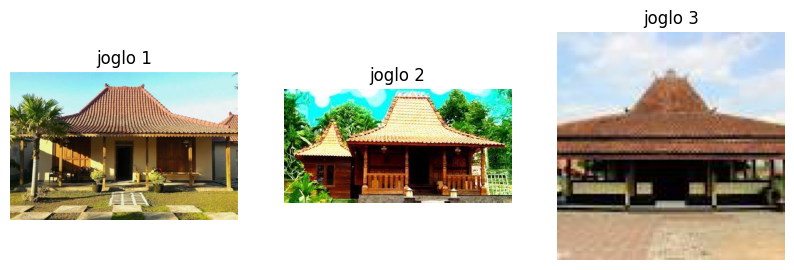


Menampilkan sample gambar kelas: gadang


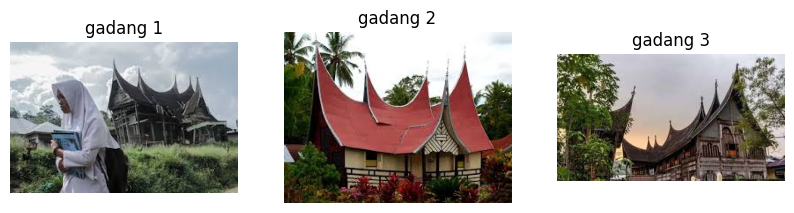

In [30]:
import os
import random
from PIL import Image

base_dir = '/content/drive/MyDrive/Deep Learning/CNN Dataset'
kelas_list = ['joglo', 'gadang']

for kelas in kelas_list:
    folder = os.path.join(base_dir, kelas)
    file_list = os.listdir(folder)

    # Ambil 3 sampel gambar secara acak
    sample_files = random.sample(file_list, 3)

    print(f"\nMenampilkan sample gambar kelas: {kelas}")

    plt.figure(figsize=(10, 3))
    for i, fname in enumerate(sample_files):
        img_path = os.path.join(folder, fname)
        img = Image.open(img_path)

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{kelas} {i+1}")
        plt.axis("off")

    plt.show()

### **Pengecekan Ukuran**

Bagian ini bertujuan untuk melihat ukuran gambar agar diketahui apakah dataset konsisten dan untuk menentukan ukuran input pada model.

In [31]:
import numpy as np

print("Cek dimensi beberapa gambar:")

for kelas in kelas_list:
    folder = os.path.join(base_dir, kelas)
    file_list = os.listdir(folder)

    sample_files = random.sample(file_list, 3)  # tetap acak

    print(f"\nKelas: {kelas}")
    for fname in sample_files:
        img_path = os.path.join(folder, fname)
        img = Image.open(img_path)
        arr = np.array(img)
        print(f"{fname} -> {arr.shape}")

Cek dimensi beberapa gambar:

Kelas: joglo
148 (141).png -> (474, 474, 4)
4.jpeg -> (180, 270, 3)
148 (190).png -> (259, 194, 4)

Kelas: gadang
y56657656h5.jpg -> (177, 284, 3)
images - 2025-11-24T133935.932.jpg -> (183, 275, 3)
images - 2025-11-24T133937.525.jpg -> (50, 50, 3)


Hasil pengecekan menunjukkan bahwa ukuran gambar pada kedua kelas tidak seragam, baik dari sisi tinggi maupun lebar. Selain itu, sebagian gambar pada kelas joglo memiliki empat channel (RGBA), sedangkan gambar pada kelas gadang menggunakan tiga channel (RGB). Perbedaan ini wajar pada dataset mentah dan akan distandardisasi pada tahap preprocessing melalui proses resize dan konversi channel.

### **Distribusi Jumlah Gambar per Kelas**

Kode berikut menampilkan grafik batang sederhana untuk memvisualisasikan perbandingan jumlah data antar kelas.

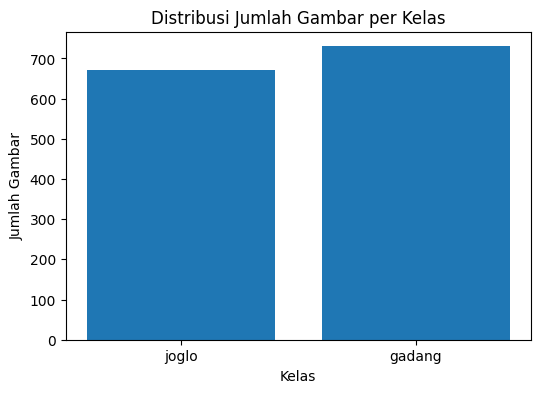

In [32]:
# Visualisasi distribusi jumlah data
plt.figure(figsize=(6,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

### **Persiapan dan Pembagian Dataset**

Pada tahap ini, dilakukan konfigurasi data loader untuk mempersiapkan citra agar sesuai dengan spesifikasi input model. Proses ini meliputi standardisasi teknis tanpa mengubah karakteristik data asli, yaitu:

Rescaling (Normalisasi): Mengonversi nilai piksel dari rentang 0-255 menjadi rentang 0-1 untuk mempercepat proses komputasi numerik.

Resizing (Penyeragaman Dimensi): Mengubah resolusi seluruh citra menjadi 150x150 piksel secara otomatis saat data dimuat.

Data Splitting (Pembagian Data): Memisahkan dataset menjadi 80% data latih (training) dan 20% data validasi (validation) untuk keperluan evaluasi model.

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menentukan direktori dan parameter gambar
TRAIN_DIR = base_dir
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# 1. Konfigurasi Generator Data (Standar Teknis)
# Hanya melakukan rescaling dan pembagian data (split)
train_datagen = ImageDataGenerator(
    rescale=1./255,      # Normalisasi nilai piksel
    validation_split=0.2 # Pembagian 20% untuk validasi
)

# 2. Memuat Data Latih (Training Set)
print("Memuat Data Latih (80%):")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

# 3. Memuat Data Validasi (Validation Set)
print("\nMemuat Data Validasi (20%):")
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

Memuat Data Latih (80%):
Found 1122 images belonging to 2 classes.

Memuat Data Validasi (20%):
Found 280 images belonging to 2 classes.


## **Pembangunan Arsitektur Model Baseline (Skenario 1)**

Pada eksperimen pertama ini, kita akan membangun sebuah model Convolutional Neural Network (CNN) yang berfungsi sebagai baseline atau tolok ukur performa awal. Arsitektur yang digunakan disusun secara sekuensial, artinya lapisan-lapisan (layers) di dalamnya ditumpuk secara berurutan dari input hingga output.

1. **Input Layer**: Lapisan ini menerima data citra yang telah diubah ukurannya
menjadi 150x150 piksel dengan 3 kanal warna (RGB).

2. **Convolutional Layers (Conv2D**): Ini adalah inti dari CNN. Lapisan ini bertugas memindai gambar menggunakan "filter" untuk mengekstraksi fitur-fitur visual penting.

- Pada awalnya, model akan belajar mengenali fitur sederhana seperti garis dan tepian.

- Semakin dalam lapisannya, model akan mulai mengenali pola yang lebih kompleks seperti bentuk atap atau ornamen.

- Fungsi aktivasi ReLU digunakan untuk mempercepat proses belajar dengan mengabaikan nilai negatif.

3. **Max Pooling Layers** (MaxPooling2D): Setelah fitur diekstraksi, lapisan ini berfungsi untuk memperkecil ukuran data (downsampling) dengan hanya mengambil nilai piksel yang paling dominan (maksimum). Tujuannya adalah mengurangi beban komputasi dan membuat model lebih fokus pada fitur utama, bukan detail kecil yang tidak relevan.

4. **Flatten Layer**: Lapisan ini bertugas mengubah data fitur yang berbentuk matriks 2 dimensi menjadi vektor 1 dimensi (deretan angka panjang). Ini adalah jembatan penghubung antara bagian ekstraksi fitur (CNN) dengan bagian klasifikasi.

5. **Dense Layer** (Fully Connected): Ini adalah jaringan saraf tiruan biasa yang bertugas mengolah vektor fitur tadi untuk mengambil keputusan.

- Dense (512): Lapisan tersembunyi dengan 512 neuron untuk memproses informasi secara mendalam.

- Output Layer (1): Lapisan terakhir yang hanya memiliki 1 neuron dengan fungsi aktivasi Sigmoid. Fungsi ini akan menghasilkan nilai probabilitas antara 0 hingga 1, yang merepresentasikan keputusan akhir model: apakah gambar tersebut masuk kategori kelas 0 (Gadang) atau kelas 1 (Joglo).

In [35]:
import tensorflow as tf

# --- TAHAP 1: DEFINISI ARSITEKTUR MODEL ---

# Inisialisasi Model Sekuensial
model_baseline = tf.keras.models.Sequential([
    # Layer Konvolusi 1: Ekstraksi fitur dasar
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer Konvolusi 2: Ekstraksi fitur lanjutan
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Layer Konvolusi 3: Ekstraksi fitur kompleks
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten: Transformasi data 2D ke 1D
    tf.keras.layers.Flatten(),

    # Dense Layer: Lapisan tersembunyi untuk pemrosesan klasifikasi
    tf.keras.layers.Dense(512, activation='relu'),

    # Output Layer: Penentu keputusan akhir (0 atau 1)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Kompilasi Model (Menentukan cara belajar model)
model_baseline.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

# Menampilkan ringkasan struktur model untuk verifikasi
model_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Eksekusi Pelatihan Model (Model Training)**

Tahap ini merupakan inti dari pembelajaran mesin, di mana model akan memproses data latih secara berulang untuk mempelajari pola fitur yang membedakan kelas "Joglo" dan "Gadang". Proses ini bertujuan untuk meminimalkan nilai kesalahan (loss) dan meningkatkan akurasi prediksi.

Pada skenario baseline ini, pelatihan ditetapkan sebanyak 15 Epoch.

Definisi Epoch: Satu epoch adalah satu kali proses pembelajaran lengkap di mana model melihat seluruh dataset pelatihan (semua gambar) satu kali.

Mengapa 15 Epoch? Jumlah ini dipilih sebagai titik awal yang efisien untuk observasi.

Cukup untuk Konvergensi Awal: 15 putaran umumnya cukup bagi model CNN sederhana untuk mulai mengenali pola dasar tanpa memakan waktu komputasi yang terlalu lama.

Deteksi Overfitting: Rentang ini memungkinkan kita untuk mengamati grafik performa. Jika akurasi data latih terus naik tinggi sementara akurasi validasi stagnan atau turun sebelum epoch ke-15, itu adalah indikasi kuat terjadinya overfitting (model menghafal data, bukan memahaminya), yang nantinya akan menjadi bahan analisis penting pada bagian pembahasan.

In [36]:
print("Memulai proses pelatihan model selama 15 Epoch...")

# Melatih model menggunakan data dari generator
# history_baseline akan menyimpan log akurasi/loss setiap epoch untuk visualisasi nanti
history_baseline = model_baseline.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    verbose=1
)

print("\nPelatihan Selesai.")

Memulai proses pelatihan model selama 15 Epoch...
Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 432s 12s/step - accuracy: 0.5669 - loss: 0.9600 - val_accuracy: 0.7969 - val_loss: 0.4605
Epoch 2/15
 1/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7812 - loss: 0.4525

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.7812 - loss: 0.4525 - val_accuracy: 0.8125 - val_loss: 0.4374
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8379 - loss: 0.3555 - val_accuracy: 0.9375 - val_loss: 0.2204
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9375 - loss: 0.1517 - val_accuracy: 0.9375 - val_loss: 0.2208
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9486 - loss: 0.1660 - val_accuracy: 0.9414 - val_loss: 0.1803
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 0.0415 - val_accuracy: 0.9492 - val_loss: 0.1592
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9794 - loss: 0.0822 - val_accuracy: 0.9609 - val_loss: 0.1227
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9688 - loss: 0.0671 - val_accuracy: 0.9648 - val_loss: 0.1172
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9911 - loss: 0.0331 - val_accuracy: 0.9688 - val_loss

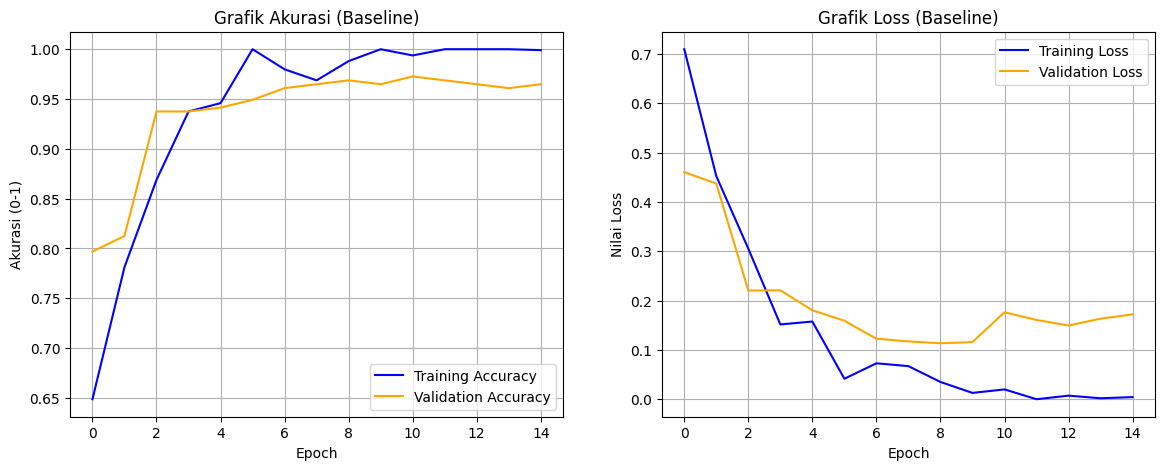

In [38]:
# Mengambil nilai akurasi dan loss dari riwayat pelatihan
acc = history_baseline.history['accuracy']
val_acc = history_baseline.history['val_accuracy']
loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# 1. Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.title('Grafik Akurasi (Baseline)')
plt.xlabel('Epoch')
plt.ylabel('Akurasi (0-1)')
plt.legend(loc='lower right')
plt.grid(True)

# 2. Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Grafik Loss (Baseline)')
plt.xlabel('Epoch')
plt.ylabel('Nilai Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

## **Analisis Hasil Eksperimen Skenario 1 (Baseline)**

Berdasarkan grafik hasil pelatihan di atas, model baseline menunjukkan kinerja yang sangat mengesankan, meskipun terdapat indikasi awal terjadinya overfitting.

Dari segi akurasi, model mampu mencapai performa sempurna pada data latih, menyentuh angka 100% mulai dari epoch ke-6 hingga akhir proses. Hal ini mengindikasikan bahwa model dapat dengan sangat cepat mempelajari dan mengenali pola fitur pada data latih. Tidak hanya itu, akurasi pada data validasi juga sangat tinggi dan stabil di kisaran 96% hingga 97% pada epoch terakhir. Tingginya akurasi ini menandakan kemampuan generalisasi yang cukup baik dalam membedakan antara Rumah Gadang dan Rumah Joglo, kemungkinan besar berkat perbedaan fitur visual yang sangat kontras antara kedua objek tersebut, seperti bentuk atap yang runcing versus limas.

Namun, jika melihat grafik tingkat kesalahan atau loss, terdapat pola yang perlu diwaspadai. Sementara nilai loss pada data latih terus menurun hingga mendekati nol, nilai loss pada data validasi justru mulai menunjukkan tren peningkatan atau divergen setelah epoch ke-9, naik dari 0.11 menjadi 0.17 di akhir pelatihan. Peningkatan validation loss di saat akurasi latih sudah mencapai 100% ini merupakan indikasi kuat bahwa model mulai "terlalu percaya diri" atau overfitting. Model mulai terlalu fokus menghafal data latih sehingga kemampuannya untuk beradaptasi pada data baru mulai sedikit terganggu, meskipun akurasi validasi masih terjaga di tingkat yang tinggi.

Secara keseluruhan, model baseline ini telah berhasil menetapkan standar performa yang tinggi. Akan tetapi, ketidakstabilan pada validation loss menjadi sinyal bahwa strategi mitigasi overfitting diperlukan pada eksperimen selanjutnya.

## **Kesimpulan Eksperimen Skenario 1 (Baseline)**

Berdasarkan hasil pelatihan model baseline, arsitektur Convolutional Neural Network (CNN) sederhana yang digunakan menunjukkan kinerja yang sangat signifikan. Model berhasil mencapai akurasi data latih sebesar 100% (1.0000) dan akurasi validasi mencapai 96.48%. Hasil ini menetapkan standar performa awal yang tinggi, bisa jadi ini disebabkan oleh fitur visual pada objek (Rumah Gadang vs Joglo) yang sangat kontras, sehingga, cukup mudah untuk dipelajari oleh si model.

Namun, terdapat indikasi overfitting yang terlihat dari peningkatan nilai loss pada data validasi (dari 0.11 menjadi 0.17) di akhir pelatihan, sementara loss data latih terus menurun mendekati nol. Hal ini menandakan bahwa model mulai terlalu fokus menghafal data latih dan berisiko kurang optimal jika dihadapkan pada data yang lebih bervariasi.

---

## **Penerapan Pra-pemrosesan Lanjutan dengan Augmentasi Data**

Merespons indikasi overfitting yang ditemukan pada eksperimen baseline, skenario kedua ini menerapkan strategi pra-pemrosesan yang lebih kompleks yang dikenal sebagai Augmentasi Data. Teknik ini bertujuan untuk memperkaya variasi dataset pelatihan secara artifisial tanpa menambah jumlah data fisik. Melalui pendekatan ini, setiap citra yang masuk ke dalam model akan mengalami transformasi geometris acak seperti rotasi, pergeseran posisi, pembesaran (zoom), dan pembalikan horizontal.

Penerapan augmentasi ini diharapkan dapat memaksa model untuk mempelajari fitur-fitur esensial dari objek (seperti bentuk atap) yang bersifat invarian terhadap posisi atau orientasi, alih-alih sekadar menghafal pola piksel yang statis. Penting untuk dicatat bahwa transformasi augmentasi ini hanya diterapkan secara eksklusif pada data latih untuk memperluas ruang belajar model, sedangkan data validasi tetap dipertahankan dalam kondisi aslinya (hanya melalui normalisasi) agar tetap menjadi tolak ukur evaluasi yang objektif dan konsisten.

In [42]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Konfigurasi Generator Data Latih (Dengan Augmentasi)
# Data ini akan dimanipulasi secara acak agar model belajar lebih keras
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,          # Normalisasi
    rotation_range=20,       # Putar gambar hingga 20 derajat
    width_shift_range=0.2,   # Geser horizontal hingga 20%
    height_shift_range=0.2,  # Geser vertikal hingga 20%
    shear_range=0.2,         # Efek miring (shear)
    zoom_range=0.2,          # Perbesar/perkecil hingga 20%
    horizontal_flip=True,    # Balik gambar secara horizontal
    fill_mode='nearest',     # Isi piksel kosong hasil rotasi dengan warna terdekat
    validation_split=0.2     # Tetap membagi 20% untuk validasi
)

# 2. Konfigurasi Generator Data Validasi (Tanpa Augmentasi)
# Data ujian harus "bersih" dan asli, hanya di-rescale
val_datagen_no_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# 3. Memuat Data Latih (Augmented)
print("Menyiapkan Data Latih (dengan Augmentasi):")
train_generator_aug = train_datagen_aug.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',      # Mengambil 80% data untuk dilatih & diaugmentasi
    shuffle=True,
    seed=42
)

# 4. Memuat Data Validasi (Original/Clean)
print("\nMenyiapkan Data Validasi (Tanpa Augmentasi):")
val_generator_aug = val_datagen_no_aug.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',    # Mengambil 20% data sisanya untuk ujian
    shuffle=False,
    seed=42
)

Menyiapkan Data Latih (dengan Augmentasi):
Found 1122 images belonging to 2 classes.

Menyiapkan Data Validasi (Tanpa Augmentasi):
Found 280 images belonging to 2 classes.


## **Pembangunan Arsitektur Model (Skenario 2)**

Pada tahap ini, dibangun kembali arsitektur CNN yang identik dengan skenario baseline. Konsistensi arsitektur ini dipertahankan secara sengaja untuk menerapkan prinsip eksperimen terkontrol (controlled experiment). Dengan tidak mengubah struktur model (tanpa menambahkan lapisan Dropout atau mengubah jumlah neuron), kita dapat memastikan bahwa setiap perubahan performa yang terjadi nantinya adalah murni dampak dari penerapan Augmentasi Data, bukan akibat perubahan pada model itu sendiri.

Model ini terdiri dari tiga lapisan konvolusi (Conv2D) untuk ekstraksi fitur, lapisan Max Pooling untuk reduksi dimensi, serta lapisan Dense (Fully Connected) untuk klasifikasi akhir. Arsitektur ini diharapkan cukup sederhana namun efektif untuk mempelajari fitur-fitur visual yang telah diperkaya melalui proses augmentasi.

In [43]:
import tensorflow as tf

# --- TAHAP 1: DEFINISI ARSITEKTUR MODEL (SKENARIO 2) ---

# Inisialisasi Model Sekuensial
# Struktur SAMA PERSIS dengan Baseline untuk perbandingan yang adil
model_scenario2 = tf.keras.models.Sequential([
    # Layer Konvolusi 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer Konvolusi 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Layer Konvolusi 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten
    tf.keras.layers.Flatten(),

    # Fully Connected Layer (Tanpa Dropout, sesuai Baseline)
    tf.keras.layers.Dense(512, activation='relu'),

    # Output Layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Kompilasi Model
model_scenario2.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

# Menampilkan ringkasan struktur model
model_scenario2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

## **Eksekusi Pelatihan dengan Augmentasi Data**

Pada tahap ini, model dilatih menggunakan data yang dihasilkan secara dinamis oleh generator augmentasi. Berbeda dengan skenario baseline, pada setiap epoch-nya model akan dihadapkan pada variasi citra yang berbeda-beda (hasil rotasi, pergeseran, dan transformasi lainnya).

Proses ini bertujuan untuk meningkatkan generalisasi model. Meskipun akurasi pada data latih mungkin tidak akan naik secepat pada baseline (karena variasi data yang lebih kompleks), hal ini justru diharapkan dapat menjaga stabilitas akurasi validasi dan mencegah terjadinya overfitting dini. Jumlah putaran pelatihan tetap dijaga sama, yaitu 15 epoch, untuk memastikan perbandingan yang adil.

In [44]:
print("Memulai pelatihan Skenario 2 (Data dengan Augmentasi)...")

# Melatih model menggunakan generator yang sudah diaugmentasi
# Perhatikan: variable yang dipakai adalah 'train_generator_aug'
history_scenario2 = model_scenario2.fit(
    train_generator_aug,
    steps_per_epoch=train_generator_aug.samples // BATCH_SIZE,
    epochs=15,
    validation_data=val_generator_aug, # Data validasi tetap menggunakan data asli
    validation_steps=val_generator_aug.samples // BATCH_SIZE,
    verbose=1
)

print("\nPelatihan Skenario 2 Selesai.")

Memulai pelatihan Skenario 2 (Data dengan Augmentasi)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5346 - loss: 0.9378 - val_accuracy: 0.7031 - val_loss: 0.5689
Epoch 2/15
 1/35 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.3125 - loss: 1.0930

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.3125 - loss: 1.0930 - val_accuracy: 0.8242 - val_loss: 0.4292
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7184 - loss: 0.5644 - val_accuracy: 0.8125 - val_loss: 0.4387
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 0.4639 - val_accuracy: 0.8203 - val_loss: 0.4350
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7344 - loss: 0.5264 - val_accuracy: 0.8320 - val_loss: 0.3308
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5938 - loss: 0.5594 - val_accuracy: 0.8750 - val_loss: 0.3005
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8234 - loss: 0.4037 - val_accuracy: 0.8477 - val_loss: 0.3065
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.7500 - loss: 0.4028 - val_accuracy: 0.8984 - val_loss: 0.2702
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8500 - loss: 0.3268 - val_accuracy: 0.8906 - val_loss:

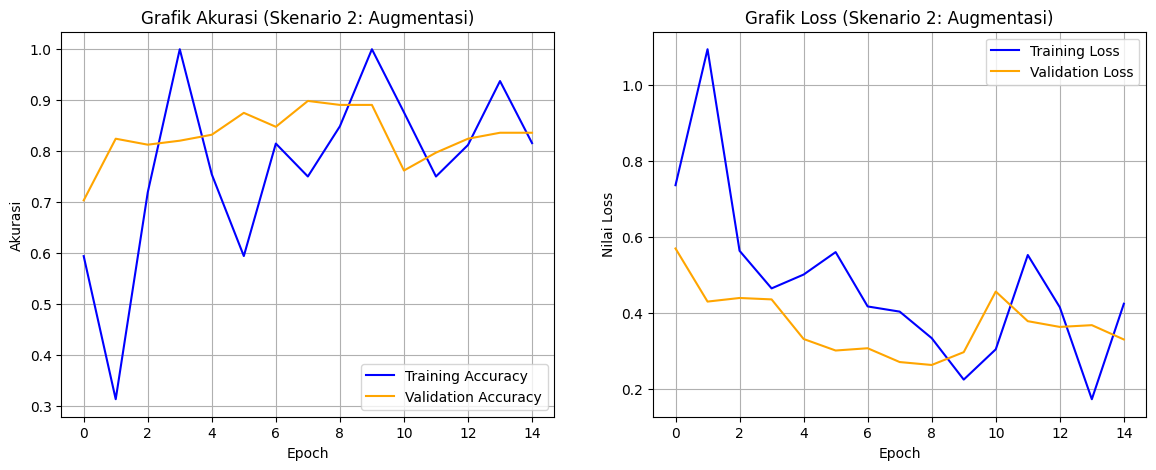

In [45]:
# Mengambil nilai dari history_scenario2
acc = history_scenario2.history['accuracy']
val_acc = history_scenario2.history['val_accuracy']
loss = history_scenario2.history['loss']
val_loss = history_scenario2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# 1. Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.title('Grafik Akurasi (Skenario 2: Augmentasi)')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.grid(True)

# 2. Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Grafik Loss (Skenario 2: Augmentasi)')
plt.xlabel('Epoch')
plt.ylabel('Nilai Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

### **Analisis Dinamika Pelatihan dengan Augmentasi**

Visualisasi grafik hasil pelatihan pada skenario kedua ini menunjukkan pola pembelajaran yang dinamis dan sehat. Pada grafik akurasi (*accuracy*), terlihat bahwa performa model pada data latih mengalami fluktuasi dan bergerak secara bertahap di kisaran 80% hingga 90%. Fenomena ini merupakan indikator positif yang menandakan bahwa model sedang bekerja keras untuk mempelajari pola data yang bervariasi. Citra yang dihasilkan oleh proses augmentasi (seperti rotasi dan pergeseran) secara efektif memberikan tantangan pada proses belajar, sehingga memaksa model untuk beradaptasi mengenali fitur-fitur esensial objek dalam berbagai kondisi, alih-alih sekadar menghafal posisi piksel.

Kestabilan model juga terlihat jelas pada grafik tingkat kesalahan (*loss*). Grafik *loss* pada data validasi tampak bergerak stabil dan selaras beriringan dengan penurunan *loss* pada data latih, tanpa menunjukkan lonjakan drastis di akhir pelatihan. Celah (*gap*) antara performa pelatihan dan validasi pun terjaga tetap sempit. Kondisi ini mengonfirmasi bahwa penerapan teknik augmentasi data berfungsi efektif dalam menjaga objektivitas pembelajaran dan meminimalisir risiko model mengalami *overfitting* atau kecenderungan untuk hanya mengenali data latih saja.

Sedang memprediksi Skenario 1...
Sedang memprediksi Skenario 2...


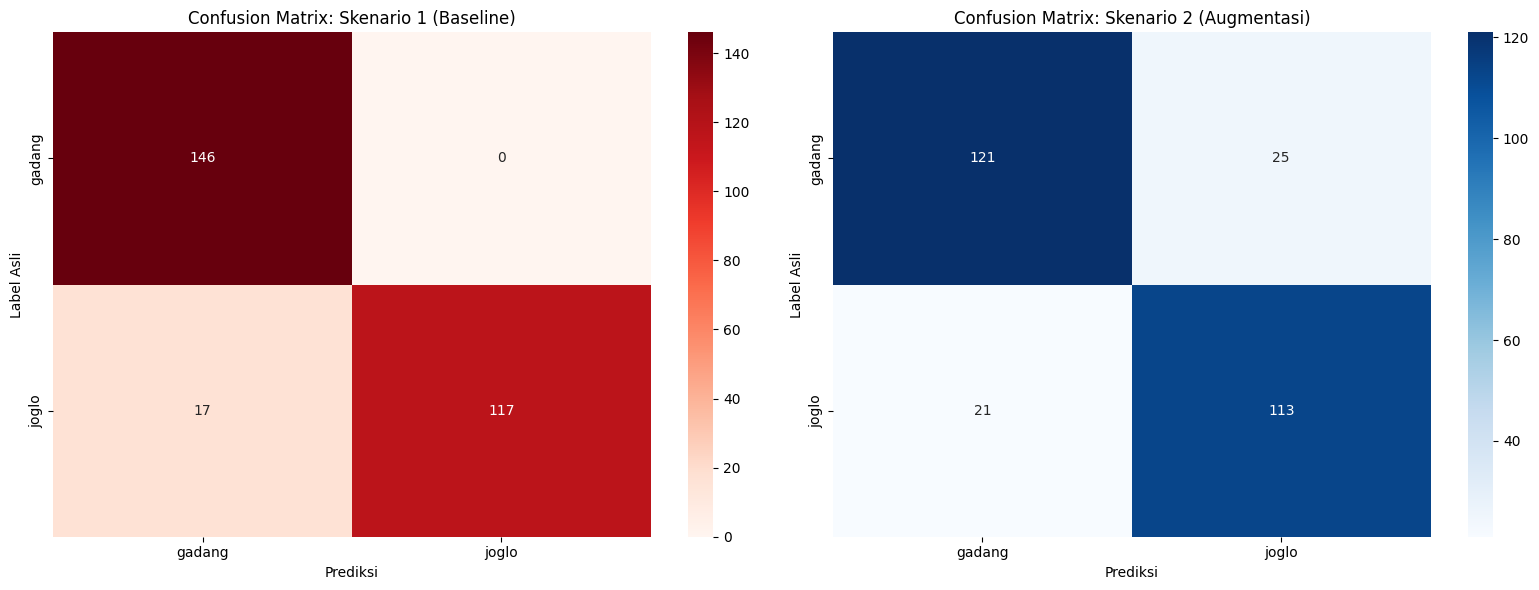


=== LAPORAN KLASIFIKASI SKENARIO 1 (BASELINE) ===
              precision    recall  f1-score   support

      gadang       0.90      1.00      0.94       146
       joglo       1.00      0.87      0.93       134

    accuracy                           0.94       280
   macro avg       0.95      0.94      0.94       280
weighted avg       0.95      0.94      0.94       280


=== LAPORAN KLASIFIKASI SKENARIO 2 (AUGMENTASI) ===
              precision    recall  f1-score   support

      gadang       0.85      0.83      0.84       146
       joglo       0.82      0.84      0.83       134

    accuracy                           0.84       280
   macro avg       0.84      0.84      0.84       280
weighted avg       0.84      0.84      0.84       280



In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- EVALUASI PERBANDINGAN: CONFUSION MATRIX (SKENARIO 1 vs SKENARIO 2) ---

# Pastikan kita menggunakan generator validasi yang sama (tanpa augmentasi) untuk fairness
# Kita reset dulu agar urutannya benar
val_generator.reset()
y_true = val_generator.classes # Kunci jawaban asli
class_names = list(val_generator.class_indices.keys()) # ['gadang', 'joglo']

# 1. Prediksi Model Skenario 1 (Baseline)
print("Sedang memprediksi Skenario 1...")
pred_1 = model_baseline.predict(val_generator, verbose=0)
y_pred_1 = (pred_1 > 0.5).astype(int)

# 2. Prediksi Model Skenario 2 (Augmentasi)
print("Sedang memprediksi Skenario 2...")
# Kita reset lagi generatornya biar urutannya pas dari awal untuk model kedua
val_generator.reset()
pred_2 = model_scenario2.predict(val_generator, verbose=0)
y_pred_2 = (pred_2 > 0.5).astype(int)

# 3. Hitung Matriks
cm_1 = confusion_matrix(y_true, y_pred_1)
cm_2 = confusion_matrix(y_true, y_pred_2)

# 4. Visualisasi Side-by-Side
plt.figure(figsize=(16, 6))

# Plot Skenario 1
plt.subplot(1, 2, 1)
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Skenario 1 (Baseline)')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi')

# Plot Skenario 2
plt.subplot(1, 2, 2)
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Skenario 2 (Augmentasi)')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi')

plt.tight_layout()
plt.show()

# 5. Tampilkan Laporan Angka
print("\n=== LAPORAN KLASIFIKASI SKENARIO 1 (BASELINE) ===")
print(classification_report(y_true, y_pred_1, target_names=class_names))

print("\n=== LAPORAN KLASIFIKASI SKENARIO 2 (AUGMENTASI) ===")
print(classification_report(y_true, y_pred_2, target_names=class_names))

### **Analisis Mendalam: Evaluasi Confusion Matrix**

Berdasarkan laporan klasifikasi dan visualisasi *confusion matrix* di atas, dapat ditarik analisis perbandingan yang mendalam antara kedua skenario:

#### **1. Analisis Skenario 1 (Baseline)**
Model ini menunjukkan perilaku yang sangat bias terhadap kelas "Gadang".
* **Perfect Recall pada Gadang (1.00):** Perhatikan bahwa model berhasil menebak **seluruh** 146 gambar Gadang dengan benar tanpa ada satupun yang terlewat (0 kesalahan pada kotak kanan atas matriks).
* **Bias Prediksi:** Namun, tingginya performa ini disertai efek samping. Model cenderung terlalu agresif memprediksi gambar sebagai "Gadang". Akibatnya, terdapat 17 gambar "Joglo" yang keliru ditebak sebagai "Gadang".
* **Interpretasi:** Ini mengonfirmasi indikasi *overfitting*. Model kemungkinan besar menghafal fitur dominan Gadang (seperti atap runcing) secara berlebihan, sehingga memaksakan fitur tersebut pada sebagian gambar Joglo. Akurasi 94% di sini bersifat semu karena didorong oleh ketimpangan ini.

#### **2. Analisis Skenario 2 (Augmentasi)**
Meskipun akurasi turun menjadi 84%, distribusi kesalahan pada model ini jauh lebih sehat dan realistis.
* **Keseimbangan (Balance):** Nilai *Precision* dan *Recall* untuk kedua kelas (Gadang dan Joglo) sangat berimbang di kisaran 0.82 - 0.85.
* **Distribusi Kesalahan:** Kesalahan tebakan tersebar merata (25 kesalahan pada Gadang dan 22 kesalahan pada Joglo). Tidak ada satu kelas yang mendominasi kelas lainnya.
* **Interpretasi:** Penurunan skor ini adalah harga yang harus dibayar untuk kemampuan generalisasi. Model ini tidak lagi "mengistimewakan" Gadang. Ia berusaha mengenali kedua kelas dengan adil. Dalam konteks implementasi nyata, model tipe ini lebih disukai karena perilakunya dapat diprediksi dan tidak bias ke satu sisi.

**Kesimpulan Evaluasi:**
Skenario 1 menang dalam angka, namun Skenario 2 menang dalam kualitas pembelajaran. Augmentasi data berhasil menghilangkan bias "hafalan" pada model, menghasilkan sistem klasifikasi yang lebih objektif meskipun dengan tingkat akurasi nominal yang lebih rendah.

# **Kesimpulan dan Analisis Komparatif Eksperimen**

Penelitian ini bertujuan untuk membangun model *Deep Learning* berbasis *Convolutional Neural Network* (CNN) yang mampu membedakan citra arsitektur Rumah Gadang dan Rumah Joglo. Berdasarkan dua skenario eksperimen yang telah dijalankan, ditemukan perbedaan perilaku model yang signifikan, baik dari segi stabilitas pembelajaran maupun keseimbangan prediksi:

#### **1. Analisis Skenario 1: Baseline (Tanpa Augmentasi)**
Pada skenario ini, model dilatih menggunakan data murni tanpa variasi tambahan.
* **Performa Kuantitatif:** Model mencetak skor akurasi validasi tertinggi (~94-96%).
* **Analisis Kritis:** Evaluasi mendalam menggunakan *Confusion Matrix* mengungkap kelemahan fatal di balik angka tinggi tersebut. Model terindikasi mengalami **bias prediksi** yang kuat terhadap kelas "Gadang" (Recall 1.00). Artinya, model cenderung memprediksi hampir semua citra sebagai Gadang, sehingga gagal mengenali sebagian besar variasi Joglo yang tidak standar.
* **Implikasi:** Tingginya akurasi pada skenario ini bersifat semu (*misleading*). Model mengalami *overfitting* dengan cara menghafal fitur dominan Gadang secara agresif, menjadikannya tidak objektif dan berisiko tinggi melakukan kesalahan tebak (False Positive) pada implementasi nyata.

#### **2. Analisis Skenario 2: Penerapan Augmentasi Data**
Skenario kedua menerapkan manipulasi geometris (rotasi, pergeseran, *zoom*) pada data latih.
* **Performa Kuantitatif:** Akurasi validasi terkoreksi menjadi sekitar **84%**.
* **Analisis Kritis:** Meskipun akurasi turun, kualitas prediksi justru meningkat secara fundamental. Laporan klasifikasi menunjukkan nilai *Precision* dan *Recall* yang sangat **seimbang** (berkisar 0.82–0.85) untuk kedua kelas.
* **Implikasi:** Augmentasi data berhasil menghilangkan bias model. Model kini memperlakukan kelas Gadang dan Joglo secara adil tanpa memihak salah satu. Kesalahan prediksi tersebar merata, menandakan bahwa model benar-benar belajar membedakan fitur visual kedua objek, bukan sekadar menebak kelas mayoritas.

### **Simpulan Akhir**

Secara komparatif, Skenario 1 unggul dalam angka nominal namun gagal dalam objektivitas. Sebaliknya, **model Skenario 2 ditetapkan sebagai model terbaik**.

Meskipun memiliki akurasi yang lebih rendah, Skenario 2 menawarkan **keseimbangan (balance) dan ketangguhan (robustness)** yang jauh lebih vital untuk aplikasi dunia nyata. Kemampuan model ini untuk memprediksi kedua kelas dengan adil dan grafik *loss* yang stabil membuktikan bahwa ia memiliki kemampuan generalisasi yang valid, bebas dari bias hafalan yang menjebak pada model *baseline*.